# Covid Workflow

### Author: Ryan Inghilterra

Covid Data Join, Explore, and export for kepler viz

Data links: 
- county shapes: https://community.esri.com/thread/24614
- county population estimates: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sq
import datetime

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
from plotly.subplots import make_subplots

import geopandas as gp
import datetime as dt

pd.options.display.max_rows = 999

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
date = dt.datetime.today().strftime("%m_%d_%Y")
print(date)

04_30_2020


## clean and explore N.Y Times covid data

In [3]:
cdf = pd.read_csv('../covid-19-data/us-counties.csv')
cdf.shape

(101108, 6)

In [4]:
cdf.head(2)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.00000,1,0
1,2020-01-22,Snohomish,Washington,53061.00000,1,0


In [5]:
MAX_DATE = cdf.date.max()
print(MAX_DATE)

2020-04-29


In [6]:
cdf.tail(2)

,date,county,state,fips,cases,deaths
101106,2020-04-29,Uinta,Wyoming,56041.00000,6,0
101107,2020-04-29,Washakie,Wyoming,56043.00000,4,0


In [7]:
cdf.county.unique()[:20]

array(['Snohomish', 'Cook', 'Orange', 'Maricopa', 'Los Angeles',
       'Santa Clara', 'Suffolk', 'San Francisco', 'Dane', 'San Diego',
       'Bexar', 'Douglas', 'Humboldt', 'Sacramento', 'Solano', 'Spokane',
       'Salt Lake', 'Marin', 'Napa', 'Sonoma'], dtype=object)

In [8]:
cdf.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths      int64
dtype: object

Exploring null values

In [9]:
cdf.isna().sum()

date         0
county       0
state        0
fips      1206
cases        0
deaths       0
dtype: int64

In [10]:
cdf[cdf.fips.isna()].tail(1)

,date,county,state,fips,cases,deaths
100921,2020-04-29,Unknown,Virginia,nan,2,0


In [11]:
cdf[cdf.fips.isna()].county.unique()

array(['New York City', 'Unknown', 'Kansas City'], dtype=object)

In [12]:
cdf[cdf.fips.isna()].state.unique()

array(['New York', 'Rhode Island', 'New Jersey', 'Puerto Rico',
       'Virgin Islands', 'Guam', 'Maine', 'Massachusetts', 'Louisiana',
       'Kentucky', 'Nevada', 'Tennessee', 'Arkansas', 'Georgia',
       'Missouri', 'Minnesota', 'California', 'Colorado', 'Florida',
       'Hawaii', 'Illinois', 'Vermont', 'Idaho', 'Michigan', 'Ohio',
       'Utah', 'Mississippi', 'Northern Mariana Islands', 'Nebraska',
       'Connecticut', 'Indiana', 'Alaska', 'Arizona', 'New Mexico',
       'Pennsylvania', 'Virginia', 'New Hampshire', 'South Dakota',
       'Washington', 'Delaware', 'Kansas', 'North Dakota', 'Maryland',
       'Iowa'], dtype=object)

In [13]:
cdf[cdf.fips.isna()].date.value_counts().head(5)

2020-04-17    33
2020-04-04    32
2020-04-18    32
2020-04-14    31
2020-04-16    31
Name: date, dtype: int64

In [14]:
cdf[cdf.fips.isna()][cdf.date == MAX_DATE].sort_values('cases', ascending=False)

/Users/ringhilterra/virtualenvs/py3dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,date,county,state,fips,cases,deaths
99942,2020-04-29,New York City,New York,nan,164852,12325
100363,2020-04-29,Unknown,Puerto Rico,nan,1433,54
99484,2020-04-29,Unknown,Michigan,nan,1350,42
98780,2020-04-29,Unknown,Guam,nan,1110,6
100368,2020-04-29,Unknown,Rhode Island,nan,1065,104
99882,2020-04-29,Unknown,New Jersey,nan,617,0
99695,2020-04-29,Kansas City,Missouri,nan,520,16
98548,2020-04-29,Unknown,Connecticut,nan,507,1
99407,2020-04-29,Unknown,Massachusetts,nan,457,5
98903,2020-04-29,Unknown,Illinois,nan,354,0


Convert fips to integer

In [15]:
cdf['fips'] = cdf['fips'].fillna(-1)
cdf['fips'] = cdf['fips'].astype('int')

In [16]:
cdf.head(2)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0


General exploratory analysis

In [17]:
cdf.tail(2)

,date,county,state,fips,cases,deaths
101106,2020-04-29,Uinta,Wyoming,56041,6,0
101107,2020-04-29,Washakie,Wyoming,56043,4,0


In [18]:
cdf.date.iloc[0]

'2020-01-21'

In [19]:
cdf.date.nunique()

100

In [20]:
cdf.describe()

,fips,cases,deaths
count,101108.00000,101108.00000,101108.00000
mean,29468.46113,193.15829,8.43320
std,15692.77168,2275.27908,148.10192
min,-1.00000,0.00000,0.00000
25%,17175.00000,3.00000,0.00000
50%,28139.00000,9.00000,0.00000
75%,44007.00000,41.00000,1.00000
max,56043.00000,164852.00000,12325.00000


In [21]:
cdf.county.nunique()

1690

In [22]:
cdf.state.nunique()

55

In [23]:
cdf.fips.nunique()

2841

In [24]:
cdf[cdf.date == MAX_DATE].sort_values('cases', ascending=False).head(10)

,date,county,state,fips,cases,deaths
99942,2020-04-29,New York City,New York,-1,164852,12325
99941,2020-04-29,Nassau,New York,36059,35505,2077
98832,2020-04-29,Cook,Illinois,17031,34880,1516
99961,2020-04-29,Suffolk,New York,36103,33265,1205
99969,2020-04-29,Westchester,New York,36119,28625,1119
98447,2020-04-29,Los Angeles,California,6037,22485,1056
99487,2020-04-29,Wayne,Michigan,26163,16494,1727
99863,2020-04-29,Bergen,New Jersey,34003,15446,1057
99870,2020-04-29,Hudson,New Jersey,34017,14596,758
99402,2020-04-29,Middlesex,Massachusetts,25017,13799,802


### New York - Manually create and handle data

From Nytime data source github:
- report a single value for New York City, comprising the cases for New York, Kings, Queens, Bronx and Richmond Counties.
- New York County FIPS = 061

In [25]:
cdf[cdf.county == 'New York City'].head(1)

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,-1,1,0


In [26]:
cdf.loc[cdf.county == 'New York City', 'fips'] = 36061

In [27]:
cdf[cdf.county == 'New York City'].tail(3)

,date,county,state,fips,cases,deaths
94262,2020-04-27,New York City,New York,36061,160499,11857
97096,2020-04-28,New York City,New York,36061,162348,12067
99942,2020-04-29,New York City,New York,36061,164852,12325


### Create state and county FIPS for join

Setup state and county fips for joining later

In [28]:
cdf['state_fips'] = cdf['fips'].apply(lambda x: str(x)[0] if (len(str(x)) == 4) else str(x)[:2])
cdf['state_fips'] = cdf['state_fips'].astype('int')

In [29]:
cdf['county_fips'] = cdf['fips'].apply(lambda x: str(x)[-3:])
cdf['county_fips'] = cdf['county_fips'].astype('int')

In [30]:
cdf.head(2)

,date,county,state,fips,cases,deaths,state_fips,county_fips
0,2020-01-21,Snohomish,Washington,53061,1,0,53,61
1,2020-01-22,Snohomish,Washington,53061,1,0,53,61


## Read in population estimates

In [31]:
pop_df = pd.read_csv('input_data/co-est2019-alldata.csv', encoding = "ISO-8859-1")
pop_df.shape

(3193, 164)

In [32]:
pop_df.head(2)

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.91750,0.57843,1.18631,1.52255,0.56349,0.62636,0.74517,1.09037,1.77379,2.48374
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.84731,6.01818,-6.22612,-3.90223,1.97044,-1.71287,4.77717,0.84966,0.54092,4.56006


In [33]:
pop_df = pop_df[['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 
                 'CENSUS2010POP', 'POPESTIMATE2019']]
pop_df.head(2)

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4903185
1,50,3,6,1,1,Alabama,Autauga County,54571,55869


## merge pop to county dataframe

In [34]:
pop_df.shape

(3193, 9)

In [35]:
cdf.shape

(101108, 8)

Need to merge to cdf dataframe using fips code

In [36]:
cdf2 = pd.merge(cdf, pop_df[['COUNTY', 'STATE','POPESTIMATE2019']],
                how='left', left_on=['county_fips', 'state_fips'], right_on=['COUNTY', 'STATE']).reset_index(drop=True)
del cdf2['COUNTY']
del cdf2['STATE']

In [37]:
cdf2.shape

(101108, 9)

Check if any of non-null cdf could not match properly on fips

In [38]:
cdf2[cdf2.POPESTIMATE2019.isna()][cdf2.fips != -1][['county', 'state', 'fips']].drop_duplicates()

/Users/ringhilterra/virtualenvs/py3dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,county,state,fips


In [39]:
cdf2.isna().sum()

date                  0
county                0
state                 0
fips                  0
cases                 0
deaths                0
state_fips            0
county_fips           0
POPESTIMATE2019    1146
dtype: int64

In [40]:
cdf2.shape

(101108, 9)

In [41]:
cdf2.sample(5)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019
17674,2020-03-28,Brown,Wisconsin,55009,6,0,55,9,264542.00000
32872,2020-04-04,Hood,Texas,48221,9,1,48,221,61643.00000
94131,2020-04-27,Knox,Nebraska,31107,1,0,31,107,8332.00000
65569,2020-04-17,Ottawa,Kansas,20143,3,0,20,143,5704.00000
97661,2020-04-28,Lawrence,Tennessee,47099,17,0,47,99,44142.00000


### Update New York City population manually

We want to update the new york city fips with sum of the population estimates of all the following counties Kings, Queens, Bronx and Richmond Counties. Since we want per capita to match the records from nytimes (they report a single value for New York City)

In [42]:
cdf2[cdf2.county == 'New York City'].tail(2)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019
97096,2020-04-28,New York City,New York,36061,162348,12067,36,61,1628706.00000
99942,2020-04-29,New York City,New York,36061,164852,12325,36,61,1628706.00000


- County FIPS: Kings=36047, Queens= 36081, Bronx=36005, Richmond Counties=36085 

In [43]:
NY_FIPS = [36047, 36081, 36005, 36085]
NY_STATE_FIP = 36
NY_COUNTY_FIPS = [47, 81, 5, 95]

In [44]:
pop_df[(pop_df.STATE == NY_STATE_FIP) & (pop_df.COUNTY.isin(NY_COUNTY_FIPS))]

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,POPESTIMATE2019
1863,50,1,2,36,5,New York,Bronx County,1385108,1418207
1884,50,1,2,36,47,New York,Kings County,2504700,2559903
1901,50,1,2,36,81,New York,Queens County,2230722,2253858
1908,50,1,2,36,95,New York,Schoharie County,32749,30999


In [45]:
ny_city_pop_sum = pop_df[(pop_df.STATE == NY_STATE_FIP) & (pop_df.COUNTY.isin(NY_COUNTY_FIPS))].POPESTIMATE2019.sum()
print(ny_city_pop_sum)

6262967


In [46]:
cdf2['POPESTIMATE2019'] =  cdf2.apply(lambda row: 
                                      (row['POPESTIMATE2019'] + ny_city_pop_sum) if row['fips'] == 36061 else row['POPESTIMATE2019'], 
                                      axis=1)

In [47]:
cdf2[cdf2.county == 'New York City'].tail(2)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019
97096,2020-04-28,New York City,New York,36061,162348,12067,36,61,7891673.00000
99942,2020-04-29,New York City,New York,36061,164852,12325,36,61,7891673.00000


## Calculate metrics per capita and new cases / deaths per day

new cases and deaths per day (should never be less than 1, so round to 0 in case there were correction in numbers)

In [48]:
df_list = []
for fip in sorted(cdf2.fips.unique()):
    adf = cdf2[cdf2.fips == fip].reset_index(drop=True)
    adf['new_day_cases'] = adf['cases'].diff().apply(lambda x: 0 if x < 0 else x)
    adf['new_day_deaths'] = adf['deaths'].diff().apply(lambda x: 0 if x < 0 else x)
    adf['new_day_cases'] = adf['new_day_cases'].fillna(0).apply(lambda x: 0 if x < 0 else x)
    adf['new_day_deaths'] = adf['new_day_deaths'].fillna(0).apply(lambda x: 0 if x < 0 else x)
    df_list.append(adf)
cdf3 = pd.concat(df_list)

In [49]:
cdf3.shape

(101108, 11)

In [50]:
cdf3[cdf3.fips == 53061].tail()

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,new_day_deaths
95,2020-04-25,Snohomish,Washington,53061,2297,103,53,61,822083.00000,30.00000,1.00000
96,2020-04-26,Snohomish,Washington,53061,2311,104,53,61,822083.00000,14.00000,1.00000
97,2020-04-27,Snohomish,Washington,53061,2355,106,53,61,822083.00000,44.00000,2.00000
98,2020-04-28,Snohomish,Washington,53061,2370,106,53,61,822083.00000,15.00000,0.00000
99,2020-04-29,Snohomish,Washington,53061,2416,106,53,61,822083.00000,46.00000,0.00000


now calc per capita

In [51]:
cdf3['cases_per_capita_100k'] = cdf3['cases'] / cdf3['POPESTIMATE2019'] * 100000
cdf3['deaths_per_capita_100k'] = cdf3['deaths'] / cdf3['POPESTIMATE2019'] * 100000
cdf3['new_day_cases_per_capita_100k'] = cdf3['new_day_cases'] / cdf3['POPESTIMATE2019'] * 100000
cdf3['new_day_deaths_per_capita_100k'] = cdf3['new_day_deaths'] / cdf3['POPESTIMATE2019'] * 100000

In [52]:
cdf3.tail(5)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k
29,2020-04-25,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000
30,2020-04-26,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000
31,2020-04-27,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000
32,2020-04-28,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000
33,2020-04-29,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000


## Population Density (merge with other pop data)

In [53]:
area_all_df = pd.read_csv('input_data/census-landarea-all.csv')
area_all_df.shape

(3195, 52)

In [54]:
area_all_df.columns

Index(['fips', 'PST045212', 'PST040210', 'PST120212', 'POP010210', 'AGE135212',
       'AGE295212', 'AGE775212', 'SEX255212', 'RHI125212', 'RHI225212',
       'RHI325212', 'RHI425212', 'RHI525212', 'RHI625212', 'RHI725212',
       'RHI825212', 'POP715211', 'POP645211', 'POP815211', 'EDU635211',
       'EDU685211', 'VET605211', 'LFE305211', 'HSG010211', 'HSG445211',
       'HSG096211', 'HSG495211', 'HSD410211', 'HSD310211', 'INC910211',
       'INC110211', 'PVY020211', 'BZA010211', 'BZA110211', 'BZA115211',
       'NES010211', 'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207',
       'SBO515207', 'SBO415207', 'SBO015207', 'MAN450207', 'WTN220207',
       'RTN130207', 'RTN131207', 'AFN120207', 'BPS030212', 'LND110210',
       'POP060210'],
      dtype='object')

In [55]:
area_df = area_all_df[['fips', 'POP060210']].sort_values('POP060210', ascending=False)
area_df.columns = ['fips', 'pop_per_sq_mile_2010']

In [56]:
area_df.head(2)

,fips,pop_per_sq_mile_2010
1892,36061,69467.50000
1885,36047,35369.10000


In [57]:
area_df.fips.nunique()

3195

In [58]:
cdf.fips.nunique()

2842

In [59]:
cdf3 = pd.merge(cdf3, area_df, how='left', on='fips')

In [60]:
print(cdf3.shape)
cdf3.tail()

(101108, 16)


,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,pop_per_sq_mile_2010
101103,2020-04-25,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000
101104,2020-04-26,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000
101105,2020-04-27,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000
101106,2020-04-28,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000
101107,2020-04-29,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000


In [61]:
cdf3[(cdf3.pop_per_sq_mile_2010.isna())  & (cdf3.fips != -1)].shape

(22, 16)

In [62]:
cdf3[(cdf3.pop_per_sq_mile_2010.isna())  & (cdf3.fips != -1)].county.unique()

array(['Oglala Lakota'], dtype=object)

## Read in, clean, and update county shapes

Read in country geometries

In [64]:
c_shp_df = gp.read_file('input_data/UScounties/UScounties.shp')

In [65]:
c_shp_df.shape

(3141, 6)

In [66]:
c_shp_df.head(2)

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283127277658 48.546679319076, ..."
1,Ferry,Washington,53,019,53019,POLYGON ((-118.8516288013387 47.94956368481996...


In [67]:
c_shp_df.dtypes

NAME            object
STATE_NAME      object
STATE_FIPS      object
CNTY_FIPS       object
FIPS            object
geometry      geometry
dtype: object

In [68]:
c_shp_df['fips'] = c_shp_df['FIPS'].astype('int')

Get center point of each county

In [69]:
c_shp_df['center_point'] = c_shp_df['geometry'].centroid

In [70]:
c_shp_df['lon'] = c_shp_df['geometry'].centroid.x
c_shp_df['lat'] = c_shp_df['geometry'].centroid.y

We want to add a small buffer to the lat / lon to make polygons

In [71]:
c_shp_df['center_geom'] = c_shp_df['geometry'].centroid.buffer(0.1)

In [72]:
c_shp_df.head(2)

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,fips,center_point,lon,lat,center_geom
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283127277658 48.546679319076, ...",27077,POINT (-94.90359451079368 48.771708924392),-94.90359,48.77171,"POLYGON ((-94.80359451079369 48.771708924392, ..."
1,Ferry,Washington,53,019,53019,POLYGON ((-118.8516288013387 47.94956368481996...,53019,POINT (-118.5183032788082 48.46948437572507),-118.51830,48.46948,POLYGON ((-118.4183032788082 48.46948437572507...


## Merge county / covid data with geometry data and final export

Get ready to merge dataframes, drop nulls to handle separately

In [73]:
cdf4 = cdf3.dropna().reset_index(drop=True)
cdf4.shape

(99940, 16)

In [74]:
cdf4.tail(2)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,pop_per_sq_mile_2010
99938,2020-04-28,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000
99939,2020-04-29,Washakie,Wyoming,56043,4,0,56,43,7805.00000,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,3.80000


In [75]:
cdf4.describe()

,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,pop_per_sq_mile_2010
count,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000,99940.00000
mean,29824.37252,192.99999,8.41146,29.72512,99.25745,166986.41155,10.30616,0.55502,72.91380,2.77676,4.30835,0.19258,349.01257
std,15443.43923,2287.98270,148.84334,15.42681,105.70146,524599.14754,98.86492,8.49314,182.52576,9.63481,19.16794,1.17835,1972.67083
min,1001.00000,1.00000,0.00000,1.00000,1.00000,463.00000,0.00000,0.00000,0.00996,0.00000,0.00000,0.00000,0.00000
25%,18025.00000,3.00000,0.00000,18.00000,33.00000,18112.00000,0.00000,0.00000,10.19888,0.00000,0.00000,0.00000,29.30000
50%,29013.00000,9.00000,0.00000,29.00000,75.00000,40350.00000,0.00000,0.00000,27.11259,0.00000,0.00000,0.00000,66.80000
75%,45011.00000,40.00000,1.00000,45.00000,129.00000,117417.00000,2.00000,0.00000,65.15082,1.71848,3.72402,0.00000,193.20000
max,56043.00000,164852.00000,12325.00000,56.00000,840.00000,10039107.00000,7837.00000,1076.00000,6250.00000,280.31868,1553.37228,70.33173,69467.50000


In [76]:
merge_df = pd.merge(cdf4, c_shp_df[['fips', 'geometry', 'center_point', 'center_geom', 'lat', 'lon']],
                    how='left', on='fips')

In [77]:
merge_df.head()

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,...,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,pop_per_sq_mile_2010,geometry,center_point,center_geom,lat,lon
0,2020-03-24,Autauga,Alabama,1001,1,0,1,1,55869.00000,0.00000,...,1.78990,0.00000,0.00000,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130
1,2020-03-25,Autauga,Alabama,1001,4,0,1,1,55869.00000,3.00000,...,7.15961,0.00000,5.36970,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130
2,2020-03-26,Autauga,Alabama,1001,6,0,1,1,55869.00000,2.00000,...,10.73941,0.00000,3.57980,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130
3,2020-03-27,Autauga,Alabama,1001,6,0,1,1,55869.00000,0.00000,...,10.73941,0.00000,0.00000,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130
4,2020-03-28,Autauga,Alabama,1001,6,0,1,1,55869.00000,0.00000,...,10.73941,0.00000,0.00000,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130


In [78]:
#merge_df.isna().sum()

In [79]:
#merge_df.dtypes

## Final Cleanup

need to convert to string or else issue with to_csv in pandas

In [80]:
merge_df['geom'] = merge_df['geometry'].astype('str')
merge_df['center_geom'] = merge_df['center_geom'].astype('str')

## Final Export For Github Repo Share

In [81]:
merge_df.head(2)

,date,county,state,fips,cases,deaths,state_fips,county_fips,POPESTIMATE2019,new_day_cases,...,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,pop_per_sq_mile_2010,geometry,center_point,center_geom,lat,lon,geom
0,2020-03-24,Autauga,Alabama,1001,1,0,1,1,55869.00000,0.00000,...,0.00000,0.00000,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130,POLYGON ((-86.82066986329349 32.34730960076057...
1,2020-03-25,Autauga,Alabama,1001,4,0,1,1,55869.00000,3.00000,...,0.00000,5.36970,0.00000,91.80000,POLYGON ((-86.82066986329349 32.34730960076057...,POINT (-86.64129633660016 32.53942589757445),POLYGON ((-86.54129633660017 32.53942589757445...,32.53943,-86.64130,POLYGON ((-86.82066986329349 32.34730960076057...


In [82]:
merge_df.columns

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'state_fips',
       'county_fips', 'POPESTIMATE2019', 'new_day_cases', 'new_day_deaths',
       'cases_per_capita_100k', 'deaths_per_capita_100k',
       'new_day_cases_per_capita_100k', 'new_day_deaths_per_capita_100k',
       'pop_per_sq_mile_2010', 'geometry', 'center_point', 'center_geom',
       'lat', 'lon', 'geom'],
      dtype='object')

In [83]:
git_final_df = merge_df[['date', 'county', 'state', 'fips', 'state_fips',
       'county_fips', 'cases', 'deaths', 'new_day_cases', 'new_day_deaths',
       'cases_per_capita_100k', 'deaths_per_capita_100k', 'new_day_cases_per_capita_100k',
       'new_day_deaths_per_capita_100k', 'POPESTIMATE2019', 'pop_per_sq_mile_2010', 'center_point',
       'lat', 'lon', 'geom']]
git_final_df = git_final_df.sort_values(['date', 'fips']).reset_index(drop=True)
print(git_final_df.shape)

(99940, 20)


In [84]:
git_final_df.head(2)

,date,county,state,fips,state_fips,county_fips,cases,deaths,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,POPESTIMATE2019,pop_per_sq_mile_2010,center_point,lat,lon,geom
0,2020-01-21,Snohomish,Washington,53061,53,61,1,0,0.00000,0.00000,0.12164,0.00000,0.00000,0.00000,822083.00000,341.80000,POINT (-121.6971581968024 48.04256748094103),48.04257,-121.69716,"POLYGON ((-121.119238109199 47.77552122801146,..."
1,2020-01-22,Snohomish,Washington,53061,53,61,1,0,0.00000,0.00000,0.12164,0.00000,0.00000,0.00000,822083.00000,341.80000,POINT (-121.6971581968024 48.04256748094103),48.04257,-121.69716,"POLYGON ((-121.119238109199 47.77552122801146,..."


### Join Back nytimes null data (CURRENTLY NOT USED)

In [85]:
# null_cdf = cdf2[cdf2.POPESTIMATE2019.isna()][['date', 'county', 'state', 'cases', 'deaths']]
# null_cdf.shape

In [86]:
# null_cdf.head(2)

In [87]:
# git_final_df2 = pd.merge(git_final_df, null_cdf, how='outer')
# git_final_df2 = git_final_df2.sort_values(['date', 'fips']).reset_index(drop=True)

In [88]:
# git_final_df2[git_final_df2.new_day_deaths.isna()].shape

In [89]:
# git_final_df2[git_final_df2.new_day_deaths.isna()].head(2)

In [90]:
# git_final_df2.head(2)

In [92]:
# git_final_df2.shape

### Final Column Renaming and Export

In [93]:
git_final_df = git_final_df.rename(columns={ 
    'POPESTIMATE2019': 'county_pop_2019_est',
    'lat': 'county_center_lat',
    'lon': 'county_center_lon',
    'geom': 'county_geom'
                                           })

In [94]:
git_final_df.head(2)

,date,county,state,fips,state_fips,county_fips,cases,deaths,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,county_pop_2019_est,pop_per_sq_mile_2010,center_point,county_center_lat,county_center_lon,county_geom
0,2020-01-21,Snohomish,Washington,53061,53,61,1,0,0.00000,0.00000,0.12164,0.00000,0.00000,0.00000,822083.00000,341.80000,POINT (-121.6971581968024 48.04256748094103),48.04257,-121.69716,"POLYGON ((-121.119238109199 47.77552122801146,..."
1,2020-01-22,Snohomish,Washington,53061,53,61,1,0,0.00000,0.00000,0.12164,0.00000,0.00000,0.00000,822083.00000,341.80000,POINT (-121.6971581968024 48.04256748094103),48.04257,-121.69716,"POLYGON ((-121.119238109199 47.77552122801146,..."


In [95]:
git_final_df.tail(2)

,date,county,state,fips,state_fips,county_fips,cases,deaths,new_day_cases,new_day_deaths,cases_per_capita_100k,deaths_per_capita_100k,new_day_cases_per_capita_100k,new_day_deaths_per_capita_100k,county_pop_2019_est,pop_per_sq_mile_2010,center_point,county_center_lat,county_center_lon,county_geom
99938,2020-04-29,Uinta,Wyoming,56041,56,41,6,0,0.00000,0.00000,29.66479,0.00000,0.00000,0.00000,20226.00000,10.10000,POINT (-110.5558079662391 41.28949347416916),41.28949,-110.55581,POLYGON ((-110.0533934603148 41.58222232622382...
99939,2020-04-29,Washakie,Wyoming,56043,56,43,4,0,0.00000,0.00000,51.24920,0.00000,0.00000,0.00000,7805.00000,3.80000,POINT (-107.686545682553 43.90339189282064),43.90339,-107.68655,POLYGON ((-107.5347665396869 43.50456760582645...


In [96]:
print(str(git_final_df.columns.values))

['date' 'county' 'state' 'fips' 'state_fips' 'county_fips' 'cases'
 'deaths' 'new_day_cases' 'new_day_deaths' 'cases_per_capita_100k'
 'deaths_per_capita_100k' 'new_day_cases_per_capita_100k'
 'new_day_deaths_per_capita_100k' 'county_pop_2019_est'
 'pop_per_sq_mile_2010' 'center_point' 'county_center_lat'
 'county_center_lon' 'county_geom']


In [99]:
# git_export_file = 'covid_data_export/covid19_us_county_{0}.csv'.format(MAX_DATE.replace('-', '_'))
# print(git_export_file)

In [110]:
# git_final_df.to_csv(git_export_file, index=False)
#git_final_df.to_csv('covid19_us_county.csv', index=False)

Also want to export only county population / shapes values to file (do not need repeat per date)

In [111]:
pop_shp_exp_file = 'us_county_pop_and_shps.csv'
pop_shp_exp_df = git_final_df[['state', 'county', 'fips', 'county_pop_2019_est', 
                              'county_center_lat', 'county_center_lon',
                             'center_point', 'county_geom']].drop_duplicates().sort_values('fips')
pop_shp_exp_df.to_csv(pop_shp_exp_file, index=False)

Also want to export only COVID-19 data without spatial columns

In [112]:
git_final_df.columns

Index(['date', 'county', 'state', 'fips', 'state_fips', 'county_fips', 'cases',
       'deaths', 'new_day_cases', 'new_day_deaths', 'cases_per_capita_100k',
       'deaths_per_capita_100k', 'new_day_cases_per_capita_100k',
       'new_day_deaths_per_capita_100k', 'county_pop_2019_est',
       'pop_per_sq_mile_2010', 'center_point', 'county_center_lat',
       'county_center_lon', 'county_geom'],
      dtype='object')

UPDATE: This is primary file with per capita, simple join can be performed on shp file

In [113]:
git_final_no_shp_file = 'covid19_us_county.csv'
git_final_no_shp_df = git_final_df[['date', 'county', 'state', 'fips', 'state_fips', 'county_fips', 'cases',
       'deaths', 'new_day_cases', 'new_day_deaths', 'cases_per_capita_100k',
       'deaths_per_capita_100k', 'new_day_cases_per_capita_100k',
       'new_day_deaths_per_capita_100k', 'county_pop_2019_est', 'pop_per_sq_mile_2010']].reset_index(drop=True)
print(git_final_no_shp_df.shape)
git_final_no_shp_df.to_csv(git_final_no_shp_file, index=False)

(99940, 16)


## Plotting

In [118]:
git_final_no_shp_df[git_final_no_shp_df.state == 'New York'].county.unique()

array(['New York City', 'Westchester', 'Nassau', 'Rockland', 'Saratoga',
       'Suffolk', 'Ulster', 'Monroe', 'Albany', 'Delaware', 'Dutchess',
       'Herkimer', 'Orange', 'Schenectady', 'Broome', 'Tioga', 'Tompkins',
       'Erie', 'Greene', 'Montgomery', 'Putnam', 'Allegany', 'Onondaga',
       'Ontario', 'Clinton', 'Rensselaer', 'Sullivan', 'Wyoming',
       'Chenango', 'Essex', 'Hamilton', 'Jefferson', 'Livingston',
       'Warren', 'Washington', 'Schoharie', 'Wayne', 'Columbia', 'Fulton',
       'Genesee', 'Niagara', 'Oneida', 'Steuben', 'Cortland', 'Madison',
       'St. Lawrence', 'Cayuga', 'Oswego', 'Otsego', 'Chemung', 'Orleans',
       'Chautauqua', 'Franklin', 'Cattaraugus', 'Schuyler', 'Lewis',
       'Seneca', 'Yates'], dtype=object)

In [119]:
ny_df = git_final_no_shp_df[git_final_no_shp_df.state == 'New York'].groupby(['date'], as_index=False).sum()[['date','cases', 'deaths']].sort_values('date')

In [120]:
ny_df.head(2)

,date,cases,deaths
0,2020-03-01,1,0
1,2020-03-02,1,0


In [121]:
rest_us_df = git_final_no_shp_df[git_final_no_shp_df.state != 'New York'].groupby(['date'], as_index=False).sum()[['date','cases', 'deaths']].sort_values('date')

In [122]:
rest_us_df.head(2)

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0


In [123]:
import datetime

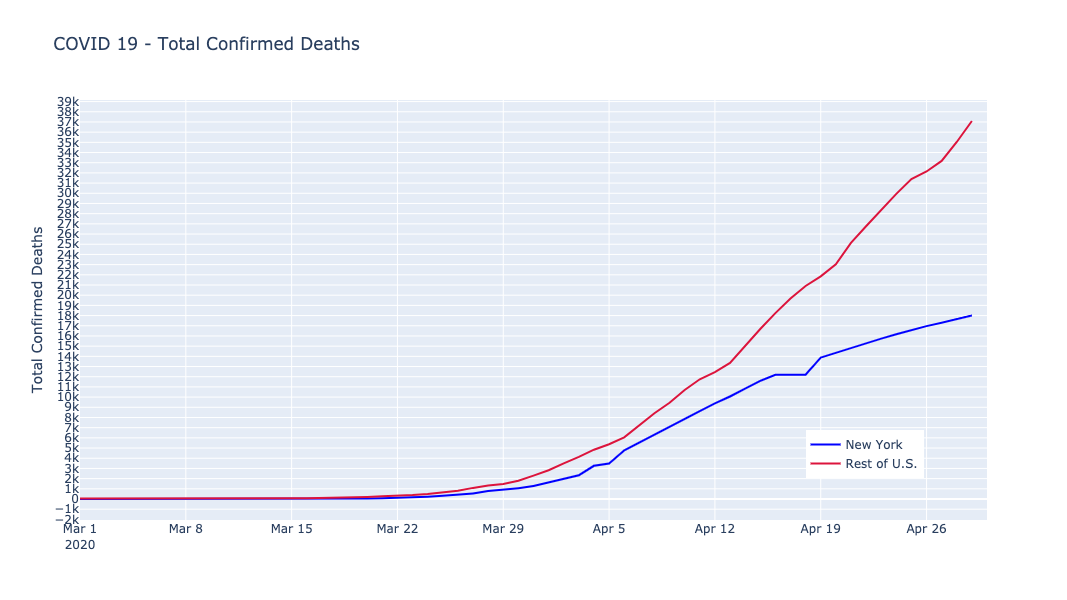

In [124]:
fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(x=ny_df['date'], y=ny_df['deaths'],
   name='New York', marker_color='blue'
), row=1, col=1)

fig.add_trace(go.Scatter(x=rest_us_df['date'], y=rest_us_df['deaths'],
   name='Rest of U.S.', marker_color='crimson'
), row=1, col=1)


# fig.add_trace(go.Scatter(x=test_df['date'], y=test_df['cases'],
#    name='New York Confirmed Cases'
# ), row=1, col=1)


fig_title = 'COVID 19 - Total Confirmed Deaths'
fig.update_yaxes(dtick=1000, title='Total Confirmed Deaths', row=1, col=1)
fig.update_xaxes(range=[datetime.date(2020, 3, 1), datetime.date(2020, 4, 30)], row=1, col=1)
fig.update_layout(height=600, width=800, 
                  title=fig_title,
                  showlegend=True,
                 legend=dict(x=0.8, y=0.1))

py.offline.iplot(fig)

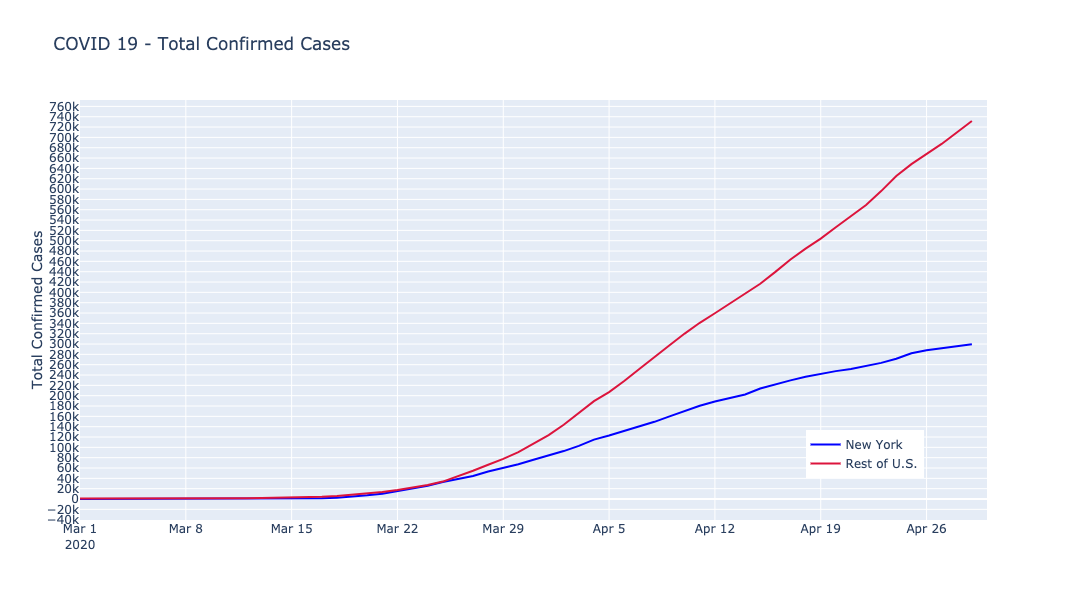

In [125]:
fig = make_subplots(rows=1, cols=1)


fig.add_trace(go.Scatter(x=ny_df['date'], y=ny_df['cases'],
   name='New York', marker_color='blue'
), row=1, col=1)

fig.add_trace(go.Scatter(x=rest_us_df['date'], y=rest_us_df['cases'],
   name='Rest of U.S.', marker_color='crimson'
), row=1, col=1)


# fig.add_trace(go.Scatter(x=test_df['date'], y=test_df['cases'],
#    name='New York Confirmed Cases'
# ), row=1, col=1)


fig_title = 'COVID 19 - Total Confirmed Cases'
fig.update_yaxes(dtick=20000, title='Total Confirmed Cases', row=1, col=1)
fig.update_xaxes(range=[datetime.date(2020, 3, 1), datetime.date(2020, 4, 30)], row=1, col=1)
fig.update_layout(height=600, width=800, 
                  title=fig_title,
                  showlegend=True,
                 legend=dict(x=0.8, y=0.1))

py.offline.iplot(fig)